
# TP Diffusion Models (RLD course)

This exercise notebook will guide through the definition of a simple diffusion
model (for MNIST)

A good overview can be found in
[Lil'Log](https://lilianweng.github.io/posts/2021-07-11-diffusion-models/)
from which most of the formulas of this notebook are taken.

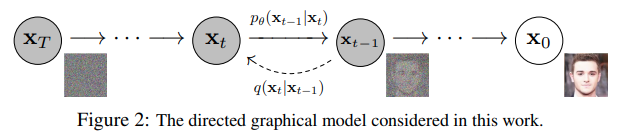 

In [2]:

!pip install easypip
import easypip

easypip.install("datamaestro-image")
easypip.install("torch>=1.12")
easypip.install("torchvision")
easypip.install("matplotlib")
easypip.install("einops")

print("Restarting of kernel...")
get_ipython().kernel.do_shutdown(True)


[notice] A new release of pip is available: 23.3 -> 23.3.2
[notice] To update, run: pip install --upgrade pip


[easypip] Installing datamaestro-image
[easypip] Installing torch>=1.12
[easypip] Installing torchvision
[easypip] Installing matplotlib
[easypip] Installing einops


KeyboardInterrupt: 

In [3]:


# Import the necessary modules
import easypip
from typing import Optional
from functools import partial
import math

from tqdm.autonotebook import tqdm

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from torchvision.utils import make_grid

%matplotlib inline
import matplotlib.pyplot as plt

from datamaestro import prepare_dataset

device = torch.device("cuda" if torch.cuda.is_available else "cpu")

/tmp/ipykernel_598359/346325263.py:7: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm
2024-01-06 20:15:40.064664: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-06 20:15:40.170898: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-06 20:15:41.486587: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRA

In [4]:
# Main experimental settings
timesteps = 200
epochs = 5

# Loading the dataset
In this notebook, we will look at images from MNIST - but you can redefine this dataset
to learn from other image distributions

In [5]:
ds = prepare_dataset("com.lecun.mnist")


class MnistDataset(Dataset):
    def __init__(self, ds):
        self.images = torch.from_numpy(ds.images.data()).unsqueeze(1) / 255.0
        self.labels = ds.labels.data()
        self.channels = 1
        self.image_shape = self.images[0, 0].shape

    def __getitem__(self, index):
        return self.images[index], self.labels[index]

    def __len__(self):
        return len(self.images)


train_data = MnistDataset(ds.train)

/tmp/ipykernel_598359/259830006.py:6: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:206.)
  self.images = torch.from_numpy(ds.images.data()).unsqueeze(1) / 255.0


In [6]:
import os

if os.environ.get("TESTING_MODE", "off") == "ON":
    timesteps = 5
    epochs = 1
    train_data.images = train_data.images[:100]
    train_data.labels = train_data.labels[:100]
    plt.show = lambda *args, **kwargs: None

# Displaying images
To visualize the results, we use the `show_image` function that takes
a batch of images (N, 1, H, W) if grayscale or (N, 3, H, W) for RGB

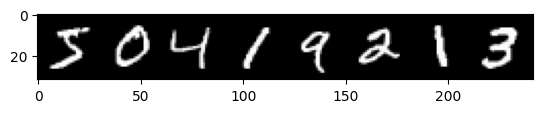

In [7]:
def show_images(images, nrow=8):
    """Show images

    Args:
        images (torch.Tensor): The batch of images
        nrow (int, optional): The number of images per row. Defaults to 8.
    """
    images_3c = images.repeat(1, 3, 1, 1) if images.shape[1] != 3 else images
    images_3c = images_3c.double().clamp(0, 1)
    grid = make_grid(images_3c, nrow=nrow).permute((1, 2, 0))
    plt.imshow(grid)
    plt.show()


# Now, show some images from the training set
show_images(train_data[0:8][0])


# Diffusion Process

Let $q(\mathbf{x}_0)$ be the real data distribution, say of "real images". We
can sample from this distribution to get an image, $\mathbf{x}_0 \sim
q(\mathbf{x}_0)$. We define the forward diffusion process $q(\mathbf{x}_t |
\mathbf{x}_{t-1})$ which adds Gaussian noise at each time step $t$, according
to a known variance schedule $0 < \beta_1 < \beta_2 < ... < \beta_T < 1$ as
$$ q(\mathbf{x}_t | \mathbf{x}_{t-1}) = \mathcal{N}(\mathbf{x}_t; \sqrt{1 -
\beta_t} \mathbf{x}_{t-1}, \beta_t \mathbf{I}). $$

Said otherwise, $$ \mathbf{x}_t = \sqrt{1 - \beta_t} \mathbf{x}_{t-1} +
\sqrt{\beta_t} \epsilon $$ with $\epsilon \sim \mathcal N(0, \mathbf{I})$.

# Schedules

There were many propositions to set the $\beta_t$ - whose general name is
*schedule*. Some are defined below:

- `LinearSchedule`
- `QuadraticSchedule`
- `SigmoidSchedule`


In [8]:
class Schedule:
    def __init__(self, betas):
        # Store basic information
        self.timesteps = len(betas)
        self.betas = betas
        self.alphas = 1.0 - betas

        # Pre-compute useful values:
        # use them in your code!
        self.alphas_cumprod = torch.cumprod(self.alphas, axis=0)
        self.sqrt_alphas_cumprod = torch.sqrt(self.alphas_cumprod)
        self.sqrt_one_minus_alphas_cumprod = torch.sqrt(1.0 - self.alphas_cumprod)
        self.sqrt_recip_alphas = torch.sqrt(1.0 / self.alphas)

        self.alphas_cumprod_prev = nn.functional.pad(
            self.alphas_cumprod[:-1], (1, 0), value=1.0
        )

        self.posterior_variance = (
            betas * (1.0 - self.alphas_cumprod_prev) / (1.0 - self.alphas_cumprod)
        )


class LinearSchedule(Schedule):
    def __init__(self, timesteps):
        beta_start = 0.0001
        beta_end = 0.02
        super().__init__(torch.linspace(beta_start, beta_end, timesteps))


class QuadraticSchedule(Schedule):
    def __init__(self, timesteps):
        beta_start = 0.0001
        beta_end = 0.02
        super().__init__(
            torch.linspace(beta_start**0.5, beta_end**0.5, timesteps) ** 2
        )


class SigmoidSchedule(Schedule):
    def __init__(self, timesteps):
        beta_start = 0.0001
        beta_end = 0.02
        betas = torch.linspace(-6, 6, timesteps)
        super().__init__(torch.sigmoid(betas) * (beta_end - beta_start) + beta_start)

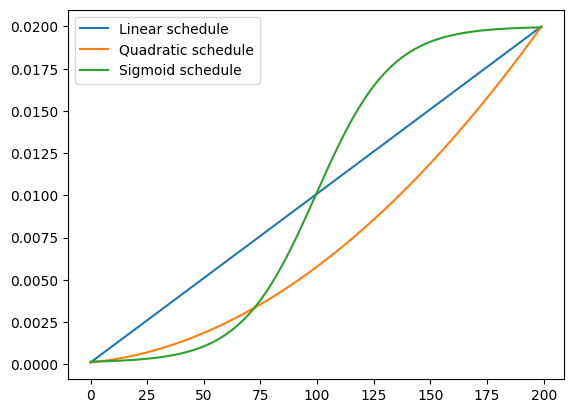

In [9]:
# Display the schedules


plt.plot(LinearSchedule(timesteps).betas, label="Linear schedule")
plt.plot(QuadraticSchedule(timesteps).betas, label="Quadratic schedule")
plt.plot(SigmoidSchedule(timesteps).betas, label="Sigmoid schedule")
plt.legend()
plt.show()


In many places, we need to take time specific values (from the schedule $\beta_t$)
or one of the derived values. The function `temporal_gather` can be used
for such manipulations:

In [10]:
def temporal_gather(a: torch.Tensor, t: torch.LongTensor, x_shape):
    """Gather values from tensor `a` using indices from `t`.

    Adds dimensions at the end of the tensor to match with the number of dimensions
    of `x_shape`
    """
    batch_size = len(t)
    out = a.gather(-1, t.cpu())
    return out.reshape(batch_size, *((1,) * (len(x_shape) - 1))).to(t.device)

In [11]:
# Example of use

temporal_gather(
    # The tensor from which we gather values
    torch.Tensor([1.1, 1.2, 1.3, 1.4]),
    # The Tensor giving
    torch.LongTensor([0, 1, 1, 0, 2]),
    # Just a shape...
    torch.zeros(1, 5, 3).shape,
)

tensor([[[1.1000]],

        [[1.2000]],

        [[1.2000]],

        [[1.1000]],

        [[1.3000]]])


# Sampling $q(x_t|x_0)$
A direct consequence of the constructed forward process $q$, as shown by [(Sohl-Dickstein et al., 2015)](https://arxiv.org/abs/1503.03585), is that we can sample $\mathbf{x}_t$ at any arbitrary noise level conditioned on $\mathbf{x}_0$ (since a sum of Gaussians is also Gaussian). This is very convenient:  we don't need to apply $q$ repeatedly in order to sample $\mathbf{x}_t$. 
We have that 
$$q(\mathbf{x}_t | \mathbf{x}_0) = \cal{N}(\mathbf{x}_t; \sqrt{\bar{\alpha}_t} \mathbf{x}_0, (1- \bar{\alpha}_t) \mathbf{I})$$
with $$\alpha_t = 1 - \beta_t\ \textrm{ and }\ \bar{\alpha}_t = \Pi_{s=1}^{t} \alpha_s$$

Let's refer to this equation as the "nice property". This means we can sample Gaussian noise and scale it appropriately and add it to $\mathbf{x}_0$ to get $\mathbf{x}_t$ directly. Note that the $\bar{\alpha}_t$ are functions of the known $\beta_t$ variance schedule and thus are also known and can be precomputed. This then allows us, during training, to **optimize random terms of the loss function $L$** (or in other words, to randomly sample $t$ during training and optimize $L_t$.

In [12]:
def q_sample(
    schedule: Schedule,
    x_0: torch.Tensor,
    t: torch.LongTensor,
    noise: Optional[torch.Tensor] = None,
):
    """Sample q(x_t|x_0) for a batch

    Args:
        schedule (Schedule): The $\beta_t$ schedule x_0 (torch.Tensor): A batch
        of images (N, C, W, H)

        t (torch.Tensor): A 1D tensor of integers (time)

        noise (torch.Tensor, optional): Sampled noise of the same dimension than
        x_0; if not given, sample one. Defaults to None.
    """
    if noise is None:
        noise = torch.randn_like(x_0)

    # Fetch the corresponding noise schedule values for the given timesteps.
    sqrt_alphas_cumprod_t = temporal_gather(schedule.sqrt_alphas_cumprod, t, x_0.shape)
    sqrt_one_minus_alphas_cumprod_t = temporal_gather(
        schedule.sqrt_one_minus_alphas_cumprod, t, x_0.shape
    )

    # Apply the forward diffusion process formula.
    x_t = sqrt_alphas_cumprod_t * x_0 + sqrt_one_minus_alphas_cumprod_t * noise

    return x_t


# Check that everything is all right
x_0 = torch.Tensor([[2.3, 1.2, 4.2], [5.4, 3.2, 1.4]])
noise = torch.Tensor(
    [
        [0.4938392937, 0.5089217424, 1.4516087770],
        [-1.1347782612, -1.3416436911, -0.1392416954],
    ]
)
expected = torch.Tensor(
    [
        [2.3507647514, 1.2699846029, 4.3878836632],
        [5.3043818474, 3.0952007771, 1.3863569498],
    ]
)
t = torch.LongTensor([3, 1])
observed = q_sample(LinearSchedule(5), x_0, t, noise=noise)
assert torch.allclose(observed, expected)

We can now show various samples with various $t$ 

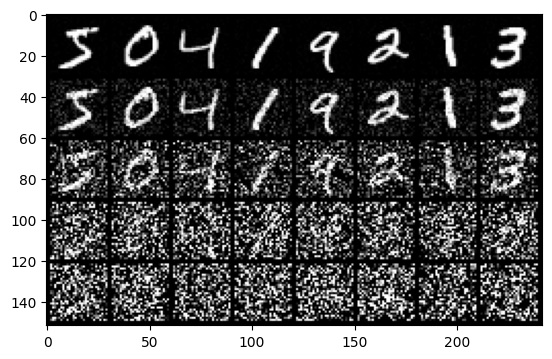

In [13]:
schedule = SigmoidSchedule(timesteps)
sample = torch.Tensor(train_data[0:8][0])

images = []
for t in [0, timesteps // 4, 2 * (timesteps // 4), 3 * (timesteps // 4), timesteps - 1]:
    x_t = q_sample(schedule, sample, torch.LongTensor([t]))
    images.append(x_t)

show_images(torch.cat(images))


# Training 

Now that we can generate samples at various time steps, we now turn to
training diffusion models, that is, we want to learn the parametric
distributions $$p_\theta(\mathbf{x}_{t-1} \vert \mathbf{x}_t) =
\mathcal{N}(\mathbf{x}_{t-1}; \boldsymbol{\mu}_\theta(\mathbf{x}_t, t),
\boldsymbol{\Sigma}_\theta(\mathbf{x}_t, t))$$

$$\begin{aligned}
- \log p_\theta(\mathbf{x}_0) 
&\leq - \log p_\theta(\mathbf{x}_0) + D_\text{KL}(q(\mathbf{x}_{1:T}\vert\mathbf{x}_0) \| p_\theta(\mathbf{x}_{1:T}\vert\mathbf{x}_0) ) \\
&= \mathbb{E}_q \Big[ \log \frac{q(\mathbf{x}_{1:T}\vert\mathbf{x}_0)}{p_\theta(\mathbf{x}_{0:T})} \Big] \\
\end{aligned}$$
It can be shown that
$$
L_{\mathrm{VLB}} = \mathbb{E}_q [\underbrace{D_\text{KL}(q(\mathbf{x}_T \vert \mathbf{x}_0) \parallel p_\theta(\mathbf{x}_T))}_{L_T} + \sum_{t=2}^T \underbrace{D_\text{KL}(q(\mathbf{x}_{t-1} \vert \mathbf{x}_t, \mathbf{x}_0) \parallel p_\theta(\mathbf{x}_{t-1} \vert\mathbf{x}_t))}_{L_{t-1}} \underbrace{- \log p_\theta(\mathbf{x}_0 \vert \mathbf{x}_1)}_{L_0} ]
$$
where $L_T$ is constant (since $x_T$ is by hypothesis Gaussian noise) wrt parameters ($q$ has no parameters)


## Reparametrization trick


As shown in [(Ho et al., 2021)](https://arxiv.org/abs/2106.15282) is that one
can instead reparametrize the mean to make the neural network learn (predict)
the added noise via a network $\mathbf{\epsilon}_\theta(\mathbf{x}_t, t)$ for
noise level $t$.

Said otherwise, 
$$
p_\theta(\mathbf{x}_{t-1} \vert \mathbf{x}_t) = \mathcal{N}(\mathbf{x}_{t-1}; \frac{1}{\sqrt{\alpha_t}} \Big( \mathbf{x}_t - \frac{1 - \alpha_t}{\sqrt{1 - \bar{\alpha}_t}} \boldsymbol{\epsilon}_\theta(\mathbf{x}_t, t) \Big), \boldsymbol{\Sigma}_\theta(\mathbf{x}_t, t)) = L_{\mathrm{VLB}}
$$


The final objective function $L_t$ - with some extra simplifications 
as shown in [(Ho et al., 2021)](https://arxiv.org/abs/2106.15282), 
is simply:
$$ L_t = \mathbb{E}_{x_0 \sim q, t \sim \mathcal U(\{1,\ldots, T\})} \|
\mathbf{\epsilon} - \mathbf{\epsilon}_\theta( \sqrt{\bar{\alpha}_t}
\mathbf{x}_0 + \sqrt{(1- \bar{\alpha}_t)  } \mathbf{\epsilon}, t) \|^2$$


# Defining the noise model

We are now interested in defining the function $\epsilon_\theta(\mathbf{x}, t)$.
To represent time, we use positional embeddings similar to those
used to define transformers. 
The code is the cell below defines a `SinusoidalPositionEmbeddings`
module that computes the embeddings of a vector of time

In [14]:
class SinusoidalPositionEmbeddings(nn.Module):
    """Positional embeddings"""

    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, time: torch.Tensor):
        device = time.device
        half_dim = self.dim // 2
        embeddings = math.log(10000) / (half_dim - 1)
        embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)
        embeddings = time[:, None] * embeddings[None, :]
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)
        return embeddings


# Example of use
t_emb = SinusoidalPositionEmbeddings(10)
t_emb(torch.LongTensor([5, 3, 2])).shape

torch.Size([3, 10])


# Image Generation: U-Net

The consensus is to use an architecture derived from U-Net, a model used
for image segmentation. The code in the next block correspond
to this model. You do not need to read the code itself (unless
you really want to).

The U-Net model has been modified in order to take as 
input a time embeddings that modifies its output. 

In [15]:
# Define the UNet architecture

from einops import rearrange
from torch import einsum


class Attention(nn.Module):
    def __init__(self, dim, heads=4, dim_head=32):
        super().__init__()
        self.scale = dim_head**-0.5
        self.heads = heads
        hidden_dim = dim_head * heads
        self.to_qkv = nn.Conv2d(dim, hidden_dim * 3, 1, bias=False)
        self.to_out = nn.Conv2d(hidden_dim, dim, 1)

    def forward(self, x):
        b, c, h, w = x.shape
        qkv = self.to_qkv(x).chunk(3, dim=1)
        q, k, v = map(
            lambda t: rearrange(t, "b (h c) x y -> b h c (x y)", h=self.heads), qkv
        )
        q = q * self.scale

        sim = einsum("b h d i, b h d j -> b h i j", q, k)
        sim = sim - sim.amax(dim=-1, keepdim=True).detach()
        attn = sim.softmax(dim=-1)

        out = einsum("b h i j, b h d j -> b h i d", attn, v)
        out = rearrange(out, "b h (x y) d -> b (h d) x y", x=h, y=w)
        return self.to_out(out)


class LinearAttention(nn.Module):
    def __init__(self, dim, heads=4, dim_head=32):
        super().__init__()
        self.scale = dim_head**-0.5
        self.heads = heads
        hidden_dim = dim_head * heads
        self.to_qkv = nn.Conv2d(dim, hidden_dim * 3, 1, bias=False)

        self.to_out = nn.Sequential(nn.Conv2d(hidden_dim, dim, 1), nn.GroupNorm(1, dim))

    def forward(self, x):
        b, c, h, w = x.shape
        qkv = self.to_qkv(x).chunk(3, dim=1)
        q, k, v = map(
            lambda t: rearrange(t, "b (h c) x y -> b h c (x y)", h=self.heads), qkv
        )

        q = q.softmax(dim=-2)
        k = k.softmax(dim=-1)

        q = q * self.scale
        context = torch.einsum("b h d n, b h e n -> b h d e", k, v)

        out = torch.einsum("b h d e, b h d n -> b h e n", context, q)
        out = rearrange(out, "b h c (x y) -> b (h c) x y", h=self.heads, x=h, y=w)
        return self.to_out(out)


def defined(x):
    return x is not None


class Residual(nn.Module):
    def __init__(self, fn):
        super().__init__()
        self.fn = fn

    def forward(self, x, *args, **kwargs):
        return self.fn(x, *args, **kwargs) + x


def Upsample(dim):
    return nn.ConvTranspose2d(dim, dim, kernel_size=4, stride=2, padding=1)


def Downsample(dim):
    return nn.Conv2d(dim, dim, kernel_size=4, stride=2, padding=1)


class Block(nn.Module):
    def __init__(self, dim, dim_out, groups=8):
        super().__init__()
        self.proj = nn.Conv2d(dim, dim_out, 3, padding=1)
        self.norm = nn.GroupNorm(groups, dim_out)
        self.act = nn.SiLU()

    def forward(self, x, scale_shift=None):
        x = self.proj(x)
        x = self.norm(x)

        if defined(scale_shift):
            assert False, "I thought you would not come here"
            scale, shift = scale_shift
            x = x * (scale + 1) + shift

        x = self.act(x)
        return x


class ResnetBlock(nn.Module):
    """https://arxiv.org/abs/1512.03385"""

    def __init__(self, dim, dim_out, *, time_emb_dim=None, groups=8):
        super().__init__()
        self.mlp = (
            nn.Sequential(nn.SiLU(), nn.Linear(time_emb_dim, dim_out))
            if time_emb_dim
            else None
        )

        self.block1 = Block(dim, dim_out, groups=groups)
        self.block2 = Block(dim_out, dim_out, groups=groups)
        self.res_conv = nn.Conv2d(dim, dim_out, 1) if dim != dim_out else nn.Identity()

    def forward(self, x: torch.Tensor, time_emb=None):
        h = self.block1(x)

        if defined(self.mlp) and defined(time_emb):
            time_emb = self.mlp(time_emb)
            # h = rearrange(time_emb, "b c -> b c 1 1") + h
            h = time_emb.unsqueeze(-1).unsqueeze(-1) + h

        h = self.block2(h)
        return h + self.res_conv(x)


class PreNorm(nn.Module):
    def __init__(self, dim, fn):
        super().__init__()
        self.fn = fn
        self.norm = nn.GroupNorm(1, dim)

    def forward(self, x):
        x = self.norm(x)
        return self.fn(x)


class Unet(nn.Module):
    def __init__(
        self,
        dim,
        init_dim=None,
        out_dim=None,
        dim_mults=(
            1,
            2,
            4,
        ),
        channels=3,
        time_dim=None,
        resnet_block_groups=4,
    ):
        """Unet architecture

        Args:
            dim (int): The dimension of the image (assumes a square image)
            init_dim (int, optional): The initialisation. Defaults to `dim // 3 * 2`.
            out_dim (int, optional): The output dimension. Defaults to channels.
            dim_mults (tuple, optional): List of ints. Defaults to (1, 2, 4).
            channels (int, optional): The number of input channels. Defaults to 3.
            time_dim (bool, optional): Time embeddings dimension. Defaults to None.
            resnet_block_groups (int, optional): Number of groups for ResNet layer normalization. Defaults to 8.
        """
        super().__init__()

        # determine dimensions
        self.channels = channels
        self.time_dim = time_dim

        # First convolution
        init_dim = init_dim or (dim // 3 * 2)
        self.init_conv = nn.Conv2d(channels, init_dim, 7, padding=3)

        dims = [init_dim, *(dim * m for m in dim_mults)]
        in_out = list(zip(dims[:-1], dims[1:]))

        resnet_block = partial(ResnetBlock, groups=resnet_block_groups)

        # layers
        self.downs = nn.ModuleList([])
        self.ups = nn.ModuleList([])
        num_resolutions = len(in_out)

        for ind, (dim_in, dim_out) in enumerate(in_out):
            is_last = ind >= (num_resolutions - 1)

            self.downs.append(
                nn.ModuleList(
                    [
                        resnet_block(dim_in, dim_out, time_emb_dim=time_dim),
                        resnet_block(dim_out, dim_out, time_emb_dim=time_dim),
                        Residual(PreNorm(dim_out, LinearAttention(dim_out))),
                        Downsample(dim_out) if not is_last else nn.Identity(),
                    ]
                )
            )

        mid_dim = dims[-1]
        self.mid_block1 = resnet_block(mid_dim, mid_dim, time_emb_dim=time_dim)
        self.mid_attn = Residual(PreNorm(mid_dim, Attention(mid_dim)))
        self.mid_block2 = resnet_block(mid_dim, mid_dim, time_emb_dim=time_dim)

        for ind, (dim_in, dim_out) in enumerate(reversed(in_out[1:])):
            is_last = ind >= (num_resolutions - 1)

            self.ups.append(
                nn.ModuleList(
                    [
                        resnet_block(dim_out * 2, dim_in, time_emb_dim=time_dim),
                        resnet_block(dim_in, dim_in, time_emb_dim=time_dim),
                        Residual(PreNorm(dim_in, LinearAttention(dim_in))),
                        Upsample(dim_in) if not is_last else nn.Identity(),
                    ]
                )
            )

        out_dim = out_dim or channels
        self.final_conv = nn.Sequential(
            resnet_block(dim, dim), nn.Conv2d(dim, out_dim, 1)
        )

    def forward(self, x, t: Optional[torch.Tensor] = None):
        assert defined(t) or not defined(self.time_dim), "No time embeddings given"

        x = self.init_conv(x)
        h = []

        # downsample
        for block1, block2, attn, downsample in self.downs:
            x = block1(x, t)
            x = block2(x, t)
            x = attn(x)
            h.append(x)
            x = downsample(x)

        # bottleneck
        x = self.mid_block1(x, t)
        x = self.mid_attn(x)
        x = self.mid_block2(x, t)

        # upsample
        for block1, block2, attn, upsample in self.ups:
            x = torch.cat((x, h.pop()), dim=1)
            x = block1(x, t)
            x = block2(x, t)
            x = attn(x)
            x = upsample(x)

        return self.final_conv(x)


# Example of use
images = train_data[0][0].unsqueeze(0).unsqueeze(0)
unet = Unet(
    # Width/Height of image
    train_data.image_shape[0],
    # Just one channel for MNIST
    channels=1,
    # Time embeddings are in $R^d$
    time_dim=5,
)


# Defining the model

In the code below, you need to define the 
noise model $\epsilon_\theta$. Don't forget
to take into account the time embeddings
using one of the PositionEmbeddings classes.

In [16]:
class Model(nn.Module):
    def __init__(self, dim, channels=1):
        """Initialize our noise model

        Args:
            dim (int): The width/height of an image
            channels (int, optional): The number of channels of the image. Defaults to 1.
        """
        super().__init__()
        self.image_size = dim
        self.channels = channels

        # À compléter...
        assert False, "Code non implémenté"

    def forward(self, x_t, time):
        # À compléter...
        assert False, "Code non implémenté"


# Initialize the model
model = Model(train_data.image_shape[0], train_data.channels)
model.to(device)

Model(
  (unet): Unet(
    (init_conv): Conv2d(1, 18, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (downs): ModuleList(
      (0): ModuleList(
        (0): ResnetBlock(
          (block1): Block(
            (proj): Conv2d(18, 28, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (norm): GroupNorm(4, 28, eps=1e-05, affine=True)
            (act): SiLU()
          )
          (block2): Block(
            (proj): Conv2d(28, 28, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (norm): GroupNorm(4, 28, eps=1e-05, affine=True)
            (act): SiLU()
          )
          (res_conv): Conv2d(18, 28, kernel_size=(1, 1), stride=(1, 1))
        )
        (1): ResnetBlock(
          (block1): Block(
            (proj): Conv2d(28, 28, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (norm): GroupNorm(4, 28, eps=1e-05, affine=True)
            (act): SiLU()
          )
          (block2): Block(
            (proj): Conv2d(28, 28, kernel_size=(3,


# Sampling

Before writing the training loop, we first set up the sampling
function - that is, the procedure that generates an image
from Gaussion noise.

You will need to complete the functions `sample` and `p_sample`. 
Note that we work with batches and that `sample` returns
the images for all time steps $x_{T-1}, \ldots, x_{0}$.

The function `sample` handles the main decoding loop:

- Sample $X_T \sim \mathcal N(\mathbf 0, \mathbf I)$
- For $t=T,\ldots,1$ compute $x_{t-1} = \mathrm{p\_sample}(x_{t}, t)$
- Return $x_0$

where the function `p_sample`, that you will code, is defined by:
1. If $t>1$, sample $\mathbf z \sim \mathcal N(\mathbf 0, \mathbf I)$, else $z = \mathbf 0$
1. $x_{t-1} = \frac 1 {\sqrt{\alpha_t}} \left( \mathbf x_t - \frac{1-\alpha_t}{\sqrt{1-\bar\alpha_t}} \mathbf{\epsilon}_\theta(\mathbf{x}_t, t)  \right) + \sigma_t \mathbf z$

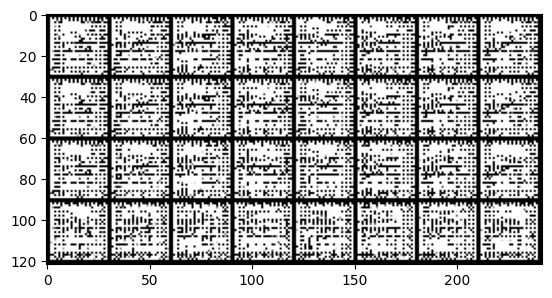

In [22]:
@torch.no_grad()
def p_sample(
    schedule: Schedule, model: Model, x: torch.Tensor, t, t_index: torch.LongTensor
):
    # À compléter...
    assert False, "Code non implémenté"


@torch.no_grad()
def sample(schedule, model, batch_size=16):
    """Sample images from the generation model

    Args:
        schedule (Schedule): The variance schedule
        model (Model): The noise model
        batch_size (int, optional): Number of images to generate. Defaults to 16.

    Returns:
        List[torch.Tensor]: List of images for each time step $x_{T-1}, \ldots, x_0$
    """
    image_size = model.image_size
    channels = model.channels
    device = next(model.parameters()).device

    # Will contain $x_{T-1}, \ldots, x_0$
    imgs = []

    # À compléter...
    assert False, "Code non implémenté"
    return imgs


# Try to generate some images
samples = sample(schedule, model, 8)
show_images(torch.cat(samples[-1:0:-50]))


# Training loop

We are now ready to code the training loop. Note that 
instead of using a L2 loss, you can use a Smooth L1
one - which is less sensitive to outliers.

Epoch: 0 Step: 0 Loss: 1.0588549375534058


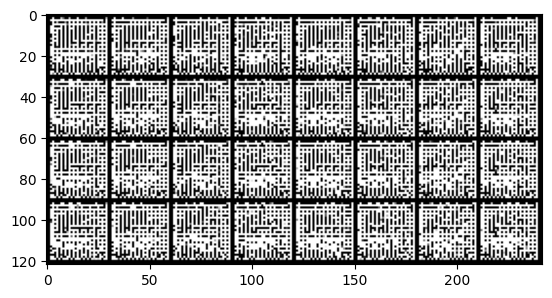

Epoch: 0 Step: 100 Loss: 0.3647572994232178
Epoch: 0 Step: 200 Loss: 0.2319667935371399
Epoch: 0 Step: 300 Loss: 0.17664368450641632
Epoch: 0 Step: 400 Loss: 0.15253177285194397
Epoch: 1 Step: 0 Loss: 0.13945241272449493


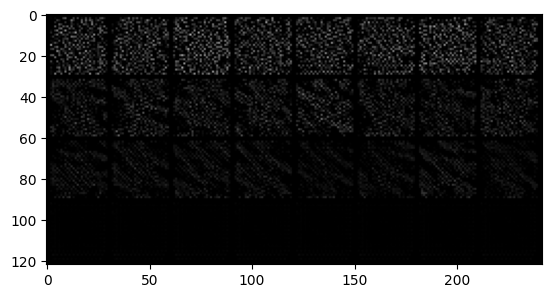

Epoch: 1 Step: 100 Loss: 0.11896080523729324
Epoch: 1 Step: 200 Loss: 0.13205325603485107
Epoch: 1 Step: 300 Loss: 0.10843547433614731
Epoch: 1 Step: 400 Loss: 0.1046249195933342
Epoch: 2 Step: 0 Loss: 0.0999620109796524


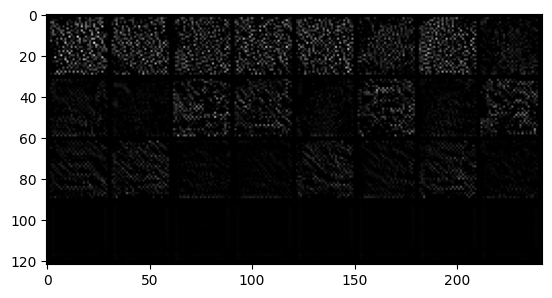

Epoch: 2 Step: 100 Loss: 0.09328199923038483
Epoch: 2 Step: 200 Loss: 0.10327056795358658
Epoch: 2 Step: 300 Loss: 0.07959465682506561
Epoch: 2 Step: 400 Loss: 0.10377824306488037
Epoch: 3 Step: 0 Loss: 0.08715798705816269


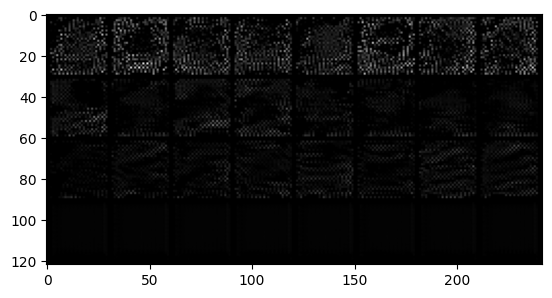

Epoch: 3 Step: 100 Loss: 0.08498841524124146
Epoch: 3 Step: 200 Loss: 0.0772208496928215
Epoch: 3 Step: 300 Loss: 0.0728159099817276
Epoch: 3 Step: 400 Loss: 0.06796842813491821
Epoch: 4 Step: 0 Loss: 0.07971712201833725


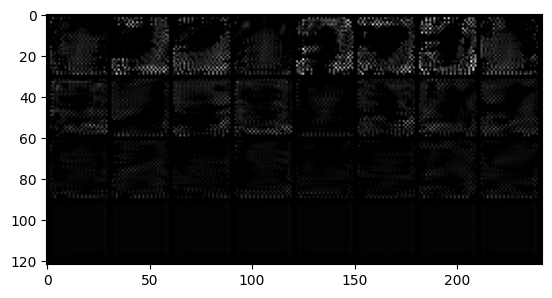

Epoch: 4 Step: 100 Loss: 0.07643331587314606
Epoch: 4 Step: 200 Loss: 0.0764782503247261
Epoch: 4 Step: 300 Loss: 0.0740814357995987
Epoch: 4 Step: 400 Loss: 0.06753025203943253


In [25]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
dataloader = DataLoader(train_data, batch_size=128, shuffle=True, pin_memory=True)

for epoch in range(epochs):
    for step, (batch, labels) in enumerate(dataloader):
        optimizer.zero_grad()

        batch_size = batch.shape[0]
        batch = batch.to(device)

        # À compléter...
        assert False, "Code non implémenté"
        loss = ...

        if step % 100 == 0:
            print("Loss:", loss.item())

        if step % 1000 == 0:
            image = sample(schedule, model, 8)
            show_images(
                torch.cat(
                    [
                        image[-timesteps // 2],
                        image[-timesteps // 3],
                        image[-timesteps // 4],
                        image[-1],
                    ]
                )
            )

        loss.backward()
        optimizer.step()

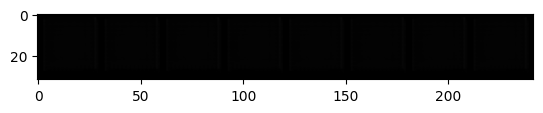

In [26]:
samples = sample(schedule, model, 8)
show_images(samples[-1])

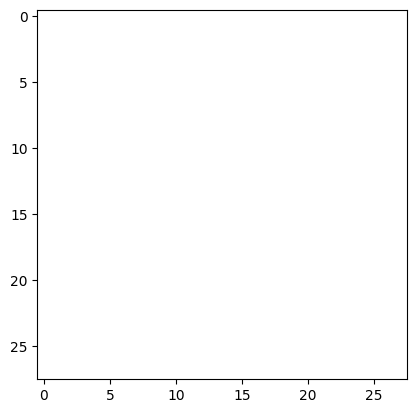

In [28]:
import matplotlib.animation as animation

random_index = 4
image_size = train_data.image_shape[0]
channels = train_data.channels

fig = plt.figure()
ims = []
for i in range(timesteps):
    im = plt.imshow(
        samples[i][random_index].reshape(image_size, image_size, channels),
        cmap="gray",
        animated=True,
    )
    ims.append([im])

animate = animation.ArtistAnimation(fig, ims, interval=50, blit=True, repeat_delay=1000)
plt.show()

In [29]:
from IPython.display import HTML, display

display(HTML(animate.to_html5_video()))


# Assignment: Conditional Classifier-Free Guidance

You will implement the classifier-free guidance proposed by J. Ho and T.
Salimans [1], with the class labels being 0 to 9 (the digit in MNIST).
You need to change your Noise model to include the class 
label $y$ that you discard with a given probability so that the
model can generate samples without class information, that is 
$$\mathbf{\epsilon}_\theta(\mathbf{x}_t, t, y)$$

During sampling, we use
$$
\tilde{\mathbf{\epsilon}}_\theta(\mathbf{x}_t, t, y)
= (1+w) \mathbf{\epsilon}_\theta(\mathbf{x}_t, t, y) + w \mathbf{\epsilon}_\theta(\mathbf{x}_t, t, \emptyset)
$$


[1] J. Ho and T. Salimans, “Classifier-Free Diffusion Guidance,” presented at
the NeurIPS 2021 Workshop on Deep Generative Models and Downstream
Applications, Nov. 2021. https://openreview.net/forum?id=qw8AKxfYbI